# Data Wrangling with Spark (Python API)

Data analysis and wrangling can be performed in two main forms in PySpark:

- Using the **Python API** (Spark Dataframe). Python is an *imperative* language, i.e., we need to define every step to be carried out to obtain the desired result. In PySpark, we define the steps with **functional programming**, i.e., we don't use for-loops, instead, transformation functions are defined and passed to `map()` or similar application methods.
- Using **SQL** (Spark Dataframe). SQL is a *declarative* language, i.e., we define the result we want to obtain and an engine under the hood takes care of the necessary steps to create that result.

The inputs from both the Python API and Spark SQL are processed by the **query optimizer Catalyst** and transformed into a **Direct Acyclic Graph (DAG)**. These DAGs represent the processing steps we want to apply on the data. Additionally, the data is internally represented as **Resilient Distributed Datasets (RDD)**. In newer versions, RDDs are abstracted to higher level structures, such as dataframes, however, we sometimes need to interact with them manually. The DAGs are applied on RDDs to obtain the desired results.

**Important**: List of available PySpark functions: [pyspark.sql.functions](https://spark.apache.org/docs/2.4.0/api/python/pyspark.sql.html#module-pyspark.sql.functions).

Note that we can chain several retrieval/analysis functions one after the other. However, these are not executed due to the *lazy evaluation* principle until we `show()` or `collect()` them:

- `show()` returns a dataframe with `n` (20, default) entries from the RDD; use for exploration.
- `collect()` returns the complete result/table from the RDD in Row elements; use only when needed.

This is the code used in this screencast: [Data Wrangling](https://www.youtube.com/watch?v=pDOlgj0FBdU). Run each code cell to understand what the code does and how it works.

**Table of Contents**

- [1. Setup](#1.-Setup)
- [2. Data Exploration](#2.-Data-Exploration)
- [3. Calculating Statistics by Hour](#3.-Calculating-Statistics-by-Hour)
- [4. Drop Rows with Missing Values](#4.-Drop-Rows-with-Missing-Values)
- [5. Users Downgrade Their Accounts](#5.-Users-Downgrade-Their-Accounts)
- [6. Extra Tips](#6.-Extra-Tips)


## 1. Setup

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf # User-Defined Function
# https://spark.apache.org/docs/2.4.0/api/python/pyspark.sql.html#module-pyspark.sql.functions
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import col

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

25/04/16 10:04:51 WARN Utils: Your hostname, kasiopeia.local resolves to a loopback address: 127.0.0.1; using 192.168.68.116 instead (on interface en0)
25/04/16 10:04:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/16 10:04:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark.sparkContext.setLogLevel("ERROR")

In [4]:
# We can use an URL, too; e.g., "hdfs://ec2-path/my_file.json"
path = "../data/sparkify_log_small.json"
user_log = spark.read.json(path)

## 2. Data Exploration 

The next cells explore the data set.

In [5]:
# Equivalent to pd.head()
user_log.take(5)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Elizabeth', gender='F', itemInSession=7, lastName='Chase', length=195.23873, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1512718541284, sessionId=5027, song='Cheryl Tweedy', status=200, ts=1513720878284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1000'),
 Row(artist='Cobra Starship Featuring Leighton Meester', auth='Logged In', firstNa

In [6]:
# Column names & type
# Important columns:
# - level: paid or free; type of subscription - that's what we're interested in
# - page: where the user is: "Next Song", "Home", "Submit Downgrade"
# - userId
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# Equivalent to pd.describe()
user_log.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|           length|level|    location|method|   page|        registration|         sessionId|    song|           status|                 ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|  count|             8347|     10000|     9664|  9664|             10000|    9664|             8347|10000|        9664| 10000|  10000|                9664|             10000|    8347|            10000|         

In [8]:
# Statistics of column "artist"
user_log.describe("artist").show()

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|             8347|
|   mean|            461.0|
| stddev|            300.0|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



In [9]:
# Statistics of column "artist"
user_log.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|             10000|
|   mean|         4436.7511|
| stddev|2043.1281541827561|
|    min|                 9|
|    max|              7144|
+-------+------------------+



In [10]:
user_log.count()

10000

In [11]:
# Column "page", drop duplicates, sort according to content in "page"
# Later we focus on the users that ar ein the page "Submit Downgrade"
user_log.select("page").dropDuplicates().sort("page").show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [12]:
# This is equivalent to an SQL query:
# We take the columns we want (i.e., the events) for one userId
# This is a user-event log
user_log.select(["userId", "firstname", "page", "song"]).where(user_log.userId == "1046").collect()

[Row(userId='1046', firstname='Kenneth', page='NextSong', song='Christmas Tears Will Fall'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Be Wary Of A Woman'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Public Enemy No.1'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Reign Of The Tyrants'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Father And Son'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='No. 5'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Seventeen'),
 Row(userId='1046', firstname='Kenneth', page='Home', song=None),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='War on war'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Killermont Street'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Black & Blue'),
 Row(userId='1046', firstname='Kenneth', page='Logout', song=None),
 Row(userId='1046', firstname='Kenneth'

## 3. Calculating Statistics by Hour

In [13]:
# UDF, udf = User-Defined Function
# This is the core of Functional Programming:
# We create a function which we'd like to apply to a column,
# then we use an applying method
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour, IntegerType())

In [14]:
# withColumn() returns the entire table/dataframe with a new column
# df.colName is a Column object, and we can apply our udf to it
user_log = user_log.withColumn("hour", get_hour(user_log.ts))
#user_log = user_log.withColumn("hour", col("ts"))

In [15]:
# Get number of songs played every hour
songs_in_hour = user_log.filter(user_log.page == "NextSong")\
                        .groupby(user_log.hour)\
                        .count()\
                        .orderBy(user_log.hour.cast("float"))

In [16]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  375|
|   1|  456|
|   2|  454|
|   3|  382|
|   4|  302|
|   5|  352|
|   6|  276|
|   7|  348|
|   8|  358|
|   9|  375|
|  10|  249|
|  11|  216|
|  12|  228|
|  13|  251|
|  14|  339|
|  15|  462|
|  16|  479|
|  17|  484|
|  18|  430|
|  19|  362|
+----+-----+
only showing top 20 rows



In [17]:
# To plot the result, we need to convert it to a Pandas
# dataframe and use Matplotlib
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

Text(0, 0.5, 'Songs played')

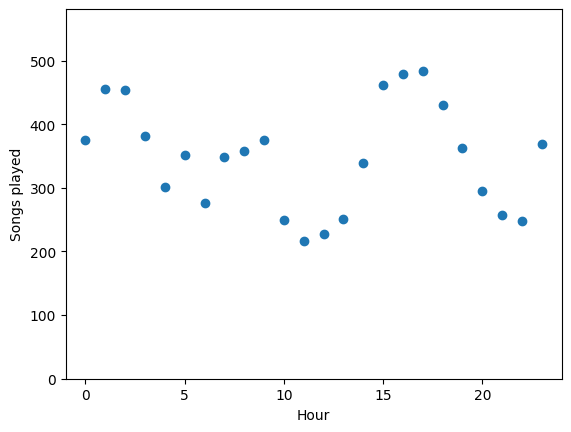

In [18]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24)
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played")

## 4. Drop Rows with Missing Values

As you'll see, it turns out there are no missing values in the userID or session columns. But there are userID values that are empty strings.

In [19]:
# Drop NAs
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])

In [20]:
# There were no NAs aparently, because we still have 1000 entries
user_log_valid.count()

10000

In [21]:
# There were no NAs, but we see there are some suspicious
# empty userIds
user_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
|  1022|
|  1025|
|  1030|
|  1035|
|  1037|
|   104|
|  1040|
|  1042|
|  1043|
|  1046|
+------+
only showing top 20 rows



In [22]:
# We filter out the empty userIds
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [23]:
# Now we have less entries
user_log_valid.count()

9664

## 5. Users Downgrade Their Accounts

Find when users downgrade their accounts and then flag those log entries. Then use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.

In [24]:
user_log_valid.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- hour: integer (nullable = true)



In [25]:
# Let's get the entries in which a user downgrades
# There's only one entry (because we have a small/reduced dataset); we take its userId
user_log_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  NULL|Logged In|    Kelly|     F|           24|  Newton|  NULL| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|NULL|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|  12|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+


In [26]:
# We investigate the events associated with this userId
# Kelly (userId 1138) played several songs after she decided to downgrade
user_log.select(["userId", "firstname", "page", "level", "song"])\
        .where(user_log.userId == "1138")\
        .collect()

[Row(userId='1138', firstname='Kelly', page='Home', level='paid', song=None),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Everybody Everybody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Gears'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Use Somebody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love Of My Life (1993 Digital Remaster)'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Down In The Valley Woe'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Treat Her Like A Lady'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song="Everybody Thinks You're An Angel"),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Fourteen Wives'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love On The Rocks'),
 Row(userId='1138', f

In [27]:
# We are going to flag the transition from level paid to free
# when a user is in the page Submit Downgrade
# We created a UDF for that; we specify the output type
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [28]:
# We apply the UDF and create a new column: "downgraded"
user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [29]:
user_log_valid.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour=23, downgraded=0)

In [ ]:
# The example goes beyond and computes a "phase" column in which a user is.
# In general, a user could be in several phases: trial, paid, free, etc.
# In this example, we have only 2 phases: 1 (paid), 0 (free); however,
# case could be extended to more phases.
# Here, it seems a bit of a over-complication, but in more complex cases,
# that's how we can operate.
# To compute the phase, we use trick:
# - we sort in chronologically descending order the entries of a user
# - we compute a cumulative sum of the "downgraded" column using a window function
from pyspark.sql import Window

In [ ]:
# Take user entries in descending order and consider the window of preceeding values,
# take all previous rows but no rows afterwards
# - partitionBy("userId"): work per user
# - orderBy(desc("ts")): sort from most recent to oldest
# - rangeBetween(Window.unboundedPreceding, 0): for each row, consider all rows from the top down to current row (cumulative)
windowval = Window.partitionBy("userId")\
                  .orderBy(desc("ts"))\
                  .rangeBetween(Window.unboundedPreceding, 0)

In [ ]:
# Create phase column
# withColumn("phase", Fsum("downgraded").over(windowval)): 
# for each row (starting from the top), sum up downgraded values from the top to that point:
# userId ts downgraded phase
# 101 1000 0 0
# 101 900 1 1
# 101 800 0 1
# 101 700 1 2
# 101 600 0 2
# Rows before the first downgrade have phase = 0
# After 1st downgrade, phase = 1
# After 2nd downgrade, phase = 2
#
# NOTE: we don't really need such a complicated approach, but this implementation
# accounts for cases in which 
# - users re-upgrade and downgrade multiple times
# - we have complex behavior phases, e.g., trial -> paid -> free → promo -> ...
user_log_valid = user_log_valid.withColumn("phase", Fsum("downgraded")\
                               .over(windowval))

In [ ]:
# If we have more than one phase, we'll see the phase values decreasing
user_log_valid.select(["userId", "firstname", "ts", "page", "level", "phase"])\
              .where(user_log.userId == "1138")\
              .sort("ts")\
              .collect()

[Row(userId='1138', firstname='Kelly', ts=1513729066284, page='Home', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729066284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729313284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729552284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729783284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730001284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730263284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730518284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730768284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513731182284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firs

25/04/15 22:26:13 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

## 6. Extra Tips & Explanations

General functions:

- `df.select()`: returns a new DataFrame with the selected columns
- `df.filter()`: filters rows using the given condition
- `df.where()`: is just an alias for `filter()`
- `df.groupBy()`: groups the DataFrame using the specified columns, so we can run aggregation on them
- `df.sort()`: returns a new DataFrame sorted by the specified column(s). By default the second parameter 'ascending' is True.
- `df.dropDuplicates()`: returns a new DataFrame with unique rows based on all or just a subset of columns
- `df.withColumn()`: returns a new DataFrame by adding a column or replacing the existing column that has the same name. The first parameter is the name of the new column, the second is an expression of how to compute it.

Aggregate functions:

```python
# Group by and the apply agg() or a specific aggregate function:
# count(), countDistinct(), avg(), max(), min()
df.groupBy("colName").min().show()
df.groupBy("colName").agg({"salary": "avg", "age": "max"}).show()
```

User-Defined Functions:

```python
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

rename_sex = udf(lambda x: 1 if x == "Male" else 0, IntegerType())
df = df.withColumn("sex", rename_sex("sex"))
```

Window functions:

> Window functions are a way of combining the values of ranges of rows in a DataFrame. When defining the window we can choose how to sort and group (with the `partitionBy()` method) the rows and how wide of a window we'd like to use (described by `rangeBetween()` or `rowsBetween()`).

A Window in Spark defines a subset of rows over which a function (like sum, average, etc.) is applied, without collapsing the rows like groupBy does.

Think of it as a rolling calculation over a “frame” of rows that moves within a group (e.g., per user).

Imagine we’re looking at Kenneth’s music activity timeline, and we want to tag each row with how many downgrade events happened after that row.

So we:

1.	Group by user
2.	Sort the timeline from most recent to oldest
3.	Add a counter that increases when we see a downgrade

This helps us split Kenneth’s activity into “phases” of behavior, like “paid phase”, then “free phase”, etc.

### Simpler Alternative

If we are confident there’s at most one downgrade per user, you could just:

```python
from pyspark.sql.window import Window
from pyspark.sql.functions import col, when, max as Fmax

# Find the timestamp of the downgrade
downgrade_ts = user_log_valid.filter(col("downgraded") == 1) \
    .groupBy("userId") \
    .agg(Fmax("ts").alias("downgrade_ts"))

# Join it back to the full log
user_with_phase = user_log_valid.join(downgrade_ts, on="userId", how="left") \
    .withColumn("phase", when(col("ts") >= col("downgrade_ts"), 1).otherwise(0))
```